# Appendix C. Machine learning: multilabel classification

The dataset consists of labelled IR spectra. Each spectrum is assigned to one or more labels, and the labels are not mutually exclusive. Therefore, we use multilabel classification techniques.

## Capstone Project 1: IR spectral analysis of organic compounds via a machine learning approach

***
**Table of contents**
#### &nbsp;&nbsp; (I) Import and prepare dataset
#### &nbsp;&nbsp; (II) Apply a dimensionality reduction technique (i.e., PCA)
#### &nbsp;&nbsp; (III) Screen multiple models simultaneously
#### &nbsp;&nbsp; (IV) Focus on one best method and improve model
#### &nbsp;&nbsp; (V) Further improve accuracy with ensemble methods
#### &nbsp;&nbsp; (VI) Summary and next steps

***

## (I) Import and prepare dataset

### (a) Import data

In [1]:
#import data
import pandas as pd

df=pd.read_csv('data/NIST_selected_organic_spectra.csv')

df.head()

,Unnamed: 0,600,604,608,612,616,620,624,628,632,...,3464,3468,3472,3476,3480,3484,3488,3492,3496,label
0,1119-40-0,0.009480,0.011373,0.008950,0.010881,0.012741,0.012765,0.011669,0.010218,0.008583,...,0.007078,0.007871,0.009175,0.010160,0.010963,0.015177,0.013968,0.014654,0.014541,ester
1,120-33-2,0.001862,0.002358,0.000965,0.001367,0.001221,0.002217,0.001162,0.000631,0.001026,...,0.007558,0.006625,0.004902,0.004450,0.003911,0.003702,0.003551,0.002494,0.002388,ester
2,120-51-4,0.011749,0.009791,0.006795,0.006387,0.006919,0.005475,0.004003,0.002257,0.002252,...,0.005814,0.004950,0.004097,0.003773,0.003183,0.002548,0.002194,0.002459,0.002356,ester
3,120650-77-3,0.004431,0.005630,0.005578,0.005711,0.004729,0.003658,0.004980,0.003962,0.003673,...,0.004496,0.005218,0.003233,0.006065,0.004307,0.004863,0.005305,0.003419,0.005081,ester
4,1335-40-6,0.026083,0.025300,0.025201,0.024101,0.023793,0.022894,0.020080,0.016694,0.013240,...,0.005708,0.005478,0.005245,0.005083,0.005195,0.005259,0.005337,0.005369,0.005188,ester


In [2]:
df.shape #check


(405, 727)

### (b) Apply multilabel  

ref.: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html

- The labels are:

In [3]:
#get the label names:
df.label.unique()

array(['ester', 'ketone', 'alcohol', 'alkane', 'alkene', 'amine',
       'aldehyde', 'acid', 'halide', 'benzene'], dtype=object)

#ref.: Brian C. Smith, "Infrared Spectral Interpretation: A Systematic Approach", CRC Press 1998.  
#we have ten labels:  
#Note: Aldehydes have the characteristic C-H stretch, denoted here as C-H_ald to differentiate from ketones.  

label_names=  
['C-H', 'C=C', \  #1,2    
'C=O', 'C-O', \  #3,4  
'O-H', 'C-N', \  #5,6  
'N-H', 'C-X', \  #7,8  
'Ar', 'C-H_ald'] #9,10    

Cheat-sheet:  
    ester=(1,3,4,,,,,,)  
    ketone=(1,3,,,,,,,)  
    alcohol=(1,4,,,,,,,)  
    alkane=(1,2,,,,,,,)  
    alkene=(1,2,,,,,,,)  
    amine=(1,6,7,,,,,,)  
    aldehyde=(1,3,10,,,,,,)  
    alcid=(1,3,4,5,,,,,)  
    halide=(1,8,,,,,,,)  
    benzene=(1,2,9,,,,,,)  


In [4]:
#1. define labels for each functional group as a list.
ester_label=[1,3,4]  
ketone_label=[1,3]  
alcohol_label=[1,4]  
alkane_label=[1,2]  
alkene_label=[1,2]  
amine_label=[1,6,7]  
aldehyde_label=[1,3,10]  
acid_label=[1,3,4,5]  
halide_label=[1,8]  
benzene_label=[1,2,9]  


In [5]:
#create labels
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer() #create object

#generate as many labels as there are entries in the respective groups and the combine it into a single array with row number matching with the Dataset
#https://stackoverflow.com/questions/19753279/repeat-a-tuple-inside-a-tuple
y_label=len(df[df.label=='ester'])*[ester_label,] + \
        len(df[df.label=='ketone'])*[ketone_label,] + \
        len(df[df.label=='alcohol'])*[alcohol_label,] + \
        len(df[df.label=='alkane'])*[alkane_label,] + \
        len(df[df.label=='alkene'])*[alkene_label,] + \
        len(df[df.label=='amine'])*[amine_label,] + \
        len(df[df.label=='aldehyde'])*[aldehyde_label,] + \
        len(df[df.label=='acid'])*[acid_label,] + \
        len(df[df.label=='halide'])*[halide_label,] + \
        len(df[df.label=='benzene'])*[benzene_label,] 

y_label=mlb.fit_transform(y_label) #convert tuples list to multilabelbinarizer
#len(y_label) #check
y_label #check


array([[1, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ..., 
       [1, 1, 0, ..., 0, 1, 0],
       [1, 1, 0, ..., 0, 1, 0],
       [1, 1, 0, ..., 0, 1, 0]])

## (II) Screen various techniques

In [6]:
#1. split datasets into train/test datasets for PCA
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( 
    df.iloc[:,1:726], y_label, test_size=0.2, random_state=13)

#2. normalize datasets
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler().fit(X_train)
standardized_X=scaler.transform(X_train)
standardized_X_test=scaler.transform(X_test)

DTR: 0.558712 (0.065795)
ETC: 0.518655 (0.075330)
ETC_E: 0.524716 (0.068475)
KNC: 0.601610 (0.060275)
RFC: 0.528220 (0.082509)


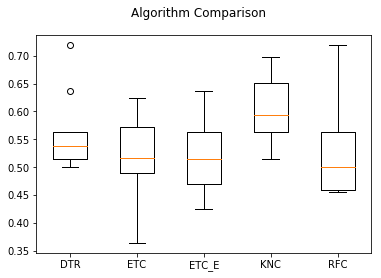

In [7]:
# Compare Algorithms
from pandas import read_csv
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


# prepare models
models = []
models.append(('DTR', DecisionTreeClassifier())) 
models.append(('ETC', ExtraTreeClassifier()))
models.append(('ETC_E', ExtraTreesClassifier()))
models.append(('KNC', KNeighborsClassifier()))
models.append(('RFC', RandomForestClassifier()))


# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'


for name, model in models: #iterate through each of the different models
    #Use k-fold validation to determine model accuracy. k-fold validation is one of many ways, but it is the gold standard way.
    try:
        kfold = KFold(n_splits=10, random_state=7) #initiate k-fold validation. Here, we use 10-folds.
        cv_results = cross_val_score(model, standardized_X, y_train, cv=kfold, scoring=scoring) #apply model in turns.
        results.append(cv_results)
        names.append(name)
    except:
        print('Error in:', name, 'and', model)
        
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

-  It is seen that ExtraTreesClassifier and KNeighborsClassifier yield the highest score of about 0.60 and a narrow standard deviation.
- Next, I will utilize dimensionality reduction technique and simultaneously perform a hyperparameter tuning on these two models.

## (III) Apply a dimensionality reduction technique (i.e., PCA)

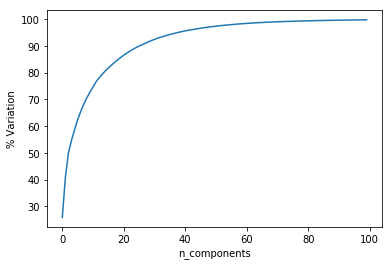

In [8]:
#Perform pca
from sklearn.decomposition import PCA

no_components=100

pca=PCA(n_components=no_components) #generate model

X_pca=pca.fit_transform(df.iloc[:,1:726])

import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(no_components),100*pca.explained_variance_ratio_.cumsum())

plt.xlabel('n_components')
plt.ylabel('% Variation')
plt.show()

- The above plot shows that n_component=100 is sufficient to capture close to 100% of all variations. Below, we will carry out hyperparameter tuning to determine the optimum parameters.

## (IV) Optimize the parameters for ExtraTreesClassifier and KNeighborsClassifier, respectively

(a) pre-process data

In [9]:
#1. split datasets into train/test datasets for PCA
from sklearn.model_selection import train_test_split

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split( 
    X_pca, y_label, test_size=0.2, random_state=13)

#2. normalize datasets

scaler=StandardScaler().fit(X_train_pca)
standardized_X_pca=scaler.transform(X_train_pca)
standardized_X_test_pca=scaler.transform(X_test_pca)

(b) ExtraTreesClassifier
- Tune n_component and max_depth simultaneously

In [10]:
#Let's tune the knn n_neighbors parameter
components = [5, 10, 15, 20, 25, 30, 50, 100] #optimize using up to 100 components
estimators = [10, 50, 100, 150, 200, 250] #and using up to 7 neighbors

ets_score=0 #temporarily stores previous score to be used to compare current with previous score
ets_best=" " #a list for storing the best parameter for the knn model

print('Finding the best parameters, please wait...')

for component in components:
    for n in estimators:
        etc = ExtraTreesClassifier(n_estimators=n, random_state=0)
        etc.fit(standardized_X_pca[:,:component], y_train)
        score = etc.score(standardized_X_test_pca[:,:component], y_test)
        
        if score>ets_score:
            ets_score=score
            ets_best='components = ', component, ', estimators = ', n,', Score = ', score
        
        #print('components = ', component, ', estimators = ', n,', Score = ', score)  

            
print('\n')
print('Best score:', ets_best)

Finding the best parameters, please wait...


Best score: ('components = ', 20, ', estimators = ', 200, ', Score = ', 0.62962962962962965)


- The highest score is 63% (components =  20 , estimators =  200). 

(c) KNeighborsClassifier
- Tune n_component and n_neighbor simultaneously

In [11]:
#Let's tune the knn n_neighbors parameter
neighbors = [1, 2, 3, 4, 5, 6, 7] #and using up to 7 neighbors

knn_score=0 #temporarily stores previous score to be used to compare current with previous score
knn_best=" " #a list for storing the best parameter for the knn model

print('Finding the best parameters, please wait...')

for component in components:
    for n in neighbors:
        knn = KNeighborsClassifier(n_neighbors=n)
        knn.fit(standardized_X_pca[:,:component], y_train)
        score = knn.score(standardized_X_test_pca[:,:component], y_test)
        
        if score>knn_score:
            knn_score=score
            knn_best='components = ', component, ', estimators = ', n,', Score = ', score
        
        #print('components = ', component, ', neighbors = ', n,', Score = ', score)  
        
print('\n')
print('Best score:', knn_best)
        

Finding the best parameters, please wait...


Best score: ('components = ', 15, ', estimators = ', 3, ', Score = ', 0.69135802469135799)


- The highest score is 69% (components =  15 , neighbors = 3). 

### (V) Further improve accuracy with ensemble methods

ref.: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble


(a) Ensemble: RandomForestClassifier

In [12]:

from sklearn.ensemble import RandomForestClassifier

rfc_score=0
rfc_params=" "

print('Finding the best parameters, please wait...')

for c in range(5,100,5):
    for est in range(1,30,1):

        clf = RandomForestClassifier(n_estimators=est)
        clf = clf.fit(standardized_X_pca[:,:c], y_train)
        score=clf.score(standardized_X_test_pca[:,:c], y_test)
        #print('score:', score)
        
        if score>rfc_score:
            rfc_score=score
            rfc_params='components: ', c, 'est:', est
print('\n')
print('best_params:', rfc_params, 'and score:', rfc_score)
    

Finding the best parameters, please wait...


best_params: ('components: ', 25, 'est:', 3) and score: 0.654320987654


- The best score is 65% (components=10 and n_estimators=29).

(b) Ensemble: ExtratreesClassifier 

In [13]:
from sklearn.ensemble import ExtraTreesClassifier

ets_score=0
ets_params=" "

print('Finding the best parameters, please wait...')

for c in range(5,100,5):
    for est in range(1,30,1):

        clf = ExtraTreesClassifier(n_estimators=est)
        clf = clf.fit(standardized_X_pca[:,:c], y_train)
        score=clf.score(standardized_X_test_pca[:,:c], y_test)
        #print('score:', score)
        
        if score>ets_score:
            ets_score=score
            ets_params='components: ', c, 'n_estimators:', est
print('\n')
print('best_params:', ets_params, 'and score:', ets_score)

Finding the best parameters, please wait...


best_params: ('components: ', 15, 'n_estimators:', 15) and score: 0.654320987654


- The best score is 65% (components=15, n_estimators=9).

### (VI) Summary and next steps

- Five machine learning models that are suitable for multilabel classification problems are assessed (i.e., DecisionTreeClassifier, ExtraTreeClassifier, ExtraTreesClassifier,  KNeighborsClassifier, and RandomForestClassifier).
- Initial screening reveals that ExtraTreesClassifier and KNeighborsClassifier perform better than the other three algorithms. 
- Next, I utilize dimensionality reduction techniques (i.e., PCA) along with the two machine learning algorithms and optimize the parameters in the respective models. 
- Using KNeighborsClassifier, the best score that is achieved is 69.0% (Components = 20 , neighbors = 5). This is a very modest score. Ensemble methods are attempted (i.e., RandomForestClassifier and ExtraTreesClassifier), but the scores did not exceed 69.0%.  
- To further improve the model accuracy, I will consider a neural network model.   
- First, I will attempt a basic neural network algorithm to achieve an accuracy above 0.90. 
- If it is not achievable, I will consider employing a convolutional neural network algorithm.